# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [6]:
'''Create dict for data from RF mice that have IHC data'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice,['Y2','Y3','Y16','Y17','Y18','Y19','A12','A13','A3','A4','A5','A6','A7'], return_indices = True)

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [7]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
y_ind = []
age_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[age_ind]))
print(len(y_sind), len(age_sind))
Nold = len(mice[age_ind])
Nyoung = len(mice[y_ind])

['Y16' 'Y17' 'Y18' 'Y19' 'Y2' 'Y3'] ['A12' 'A13' 'A3' 'A4' 'A5' 'A6' 'A7']
6 7
31 42


In [9]:
''' Use density of spatial cells to get dot colormaps for subsequent boxplots'''

fig5_folder = 'C:/Users/Python/Desktop/LocalData/Figure5/' 
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter

per99 = []
sper99 = []
mper99 = []

for m, session in zip(mice,sessions):
    
    m_99 = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        #load all spatial cell boolean
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        spatialcell = np.load(fig5_folder + spatialcell99_file)
        d['spatialcell'] = spatialcell
        spatialcells = cell_IDs[spatialcell]
        
        #print(m + ', ' + s + ' n spatial cells: '+ str(np.sum(spatialcell)))
        per99 = np.append(per99, 100*np.sum(spatialcell)/len(cell_IDs))
        sper99 = np.append(sper99, 100*np.sum(spatialcell)/len(cell_IDs))
        m_99 = np.append(m_99, np.sum(spatialcell))
        m_cells = np.append(m_cells, len(cell_IDs))
        
    mper99 = np.append(mper99, np.sum(m_99)/np.sum(m_cells))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
''' Define ColorMaps for Session & Animal Boxplots of Mice that have IHC Data (Figure 8)'''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,Nold)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,Nyoung)])
col_animal = [col_animal_young, col_animal_old]

col_session_young = []
col_session_old = []
for m, session in zip(mice, sessions):
    print(m)
    
    for s in range(0,len(session)):
        
        if m in RF_aged_mice:
            idx = np.where(mice == m)[0][0]
            col_session_old.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young,col_session_old]

label_mice = ['Y16', 'Y17', 'Y18', 'Y19', 'Y2', 'Y3','A12', 'A13', 'A3', 'A4', 'A5', 'A6', 'A7']

# set up handles
from itertools import repeat
per99 = [mper99[y_ind], mper99[age_ind]]

handles = []
for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)

A12
A13
A3
A4
A5
A6
A7
Y16
Y17
Y18
Y19
Y2
Y3


In [11]:
''' Define folder to save plots to'''

save_folder = 'C:/Users/Python/Desktop/LocalData/Figure78S8/' 

# Figure 7F, G Visualizations of RF Transcriptomic Data Correlates of Spatial Coding

Other panels in Figure 7 were generated with publicly available packages listed in the manuscript methods. As such, the only code needed to reproduce these panels is shared. Raw and processed transcriptomic data will be made available to the public upon manuscript publication

In [12]:
''' Gather Data from Spreadsheet'''

figure7f = pd.read_csv('C:/Users/Python/Downloads/7F.csv') # adjust path name
figure7f.head()

sigcorrR = np.array(figure7f.loc[(figure7f.sigFDR == 1),'r'])
nscorrR = np.array(figure7f.loc[(figure7f.sigFDR == 0),'r'])

sigcorrp = np.array(figure7f.loc[(figure7f.sigFDR == 1),'pmk'])
nscorrp = np.array(figure7f.loc[(figure7f.sigFDR == 0),'pmk'])

hapln4p = np.array(figure7f.loc[(figure7f.Gene == 'Hapln4'),'pmk'])
hapln4r = np.array(figure7f.loc[(figure7f.Gene == 'Hapln4'),'r'])
adamts3p = np.array(figure7f.loc[(figure7f.Gene == 'Adamts3'),'pmk'])
adamts3r = np.array(figure7f.loc[(figure7f.Gene == 'Adamts3'),'r'])

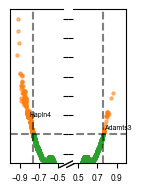

In [13]:
''' Plot Figure 7F'''

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (1.5,2),sharey = True)
fig.subplots_adjust(wspace = 0.2)
ax1.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C1', alpha = 0.5, s = 5)
ax1.scatter(nscorrR,-1*np.log10(nscorrp), color = 'C2', alpha = 0.5, s = 5)
ax1.set_xlim([-1,-0.45])
ax1.set_xticks([-0.9,-0.7,-0.5])
ax1.set_ylim([0.85,1.65])
ax2.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C1', alpha = 0.5, s = 5)
ax2.scatter(nscorrR,-1*np.log10(nscorrp), color = 'C2', alpha = 0.5, s = 5)
ax2.set_xlim([0.45,1])
ax2.set_xticks([0.5,0.7,0.9])
ax2.set_ylim([0.85,1.65])
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_right()
ax1.tick_params(labelright=False, labelsize = 6)
ax2.tick_params(labelsize = 6)
ax2.yaxis.tick_left()

ax1.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax2.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax1.vlines(np.min(nscorrR),0.85,1.65,'k','--',alpha = 0.5)
ax2.vlines(np.max(nscorrR),0.85,1.65,'k','--',alpha = 0.5)

ax1.annotate('Hapln4',(hapln4r,-1*np.log10(hapln4p)),fontsize = 5)
ax2.annotate('Adamts3',(adamts3r,-1*np.log10(adamts3p)),fontsize =5)

#add slant broken line
d = 0.5
kwargs = dict(marker=[(-1,-d),(1,d)], markersize = 12, linestyle = "none",color = 'k', mec = 'k', mew = 1, clip_on=False)
ax1.plot([1.08,1.22],[0,0], transform=ax1.transAxes,**kwargs)
#ax2.plot([0,1],[1,1], transform=ax2.transAxes,**kwargs)

plt.savefig(save_folder + '7F.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '7F.svg', dpi = 400, bbox_inches = 'tight')
plt.show()



Association btwn Young, Aged, & All Decoder Score vs. Coherence:
R [Young, Aged, All]: 
0.29936994352991936 0.8098837993395726 0.7727664743552435
P [Young, MA, Aged, All]: 
0.5142384986695967 0.02724413227163915 0.0011937429294855187


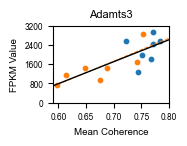


Association btwn Young, Aged, & All Decoder Score vs. Coherence:
R [Young, Aged, All]: 
0.47119318654988435 -0.7080378134897743 -0.7971449300581164
P [Young, MA, Aged, All]: 
0.2858370824862966 0.07502910637629706 0.0006396510354129063


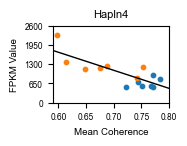

In [14]:
''' Plot 7G'''

coherence = [0.771507,0.743562,0.751875,0.722717,0.76769,0.783099,0.771744,0.598272,0.647575,0.688719,0.614267,0.674573,0.752533,0.741628]
adamts3 = [2434.00769,1278.451717,1996.709615,2555.452779,1832.066644,2567.381172,2951.50437,745.0741398,1460.752713,1463.475755,1138.184964,957.0021128,2874.030388,1701.103465]
hapln4 = [535.8996691, 708.0133348, 562.140088, 541.6174085, 579.4763986, 813.0257486, 945.0704155, 2274.470467, 1131.280868, 1239.024935, 1374.522669, 1179.153181, 1204.534184, 846.2194377]

#ADAMTS3
res = stats.linregress(coherence[:7],adamts3[:7])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(coherence[7:],adamts3[7:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(coherence,adamts3)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. Coherence:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7Gtop
fig, ax = plt.subplots(figsize = (1.5,1))
ax.set_title('Adamts3', fontsize = 8)
ax.scatter(coherence[:7],adamts3[:7], color = 'C0', label = 'Young', s = 10)
ax.scatter(coherence[7:],adamts3[7:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Mean Coherence', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([0.59,0.8])
ax.set_ylim([0,3200])
ax.set_yticks([0,800,1600,2400,3200])
ax.set_xticks([0.6,0.65,0.7,0.75,0.8])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '7Gtop.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '7Gtop.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#ADAMTS3
res = stats.linregress(coherence[:7],hapln4[:7])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(coherence[7:],hapln4[7:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(coherence,hapln4)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. Coherence:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7Gtop
fig, ax = plt.subplots(figsize = (1.5,1))
ax.set_title('Hapln4', fontsize = 8)
ax.scatter(coherence[:7],hapln4[:7], color = 'C0', label = 'Young', s = 10)
ax.scatter(coherence[7:],hapln4[7:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Mean Coherence', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([0.59,0.8])
ax.set_ylim([0,2600])
ax.set_yticks([0,650,1300,1950,2600])
ax.set_xticks([0.6,0.65,0.7,0.75,0.8])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '7Gbottom.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '7Gbottom.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


# Figure 8B-D Visualizations of PNN Density & Correlative Relationships

Figure 8A is an immunohistochemical representative image. Pre-processed images and image analysis data will be made available to the public upon manuscript publication.

In [15]:
#assemble imaging data

youngPNN = [3.01105E-05 , 2.15797E-05, 3.98246E-06, 2.2727E-05, 2.73576E-06,5.53944E-05]
agedPNN = [0.0000447565, 0.0000384606, 0.0000377460, 0.0000607957, 0.0000262604, 0.0000392334, 0.0000363791]

youngEXPNN = [0.0000081782, 0.0000041645, 0.0000039825, 0.0000030816, 0.0000023449, 0.0000201861]
agedEXPNN = [0.0000172499, 0.0000192303, 0.0000130014, 0.0000263920, 0.0000100767, 0.0000127872, 0.0000063268]

youngPVPNN = [0.0000219323,0.0000174152, 0.0000000000, 0.0000196454,0.0000003908,0.0000352083]
agedPVPNN = [0.0000275066, 0.0000192303, 0.0000247446, 0.0000344038, 0.0000161837, 0.0000264462,0.0000300523]

youngPV = [0.000140887, 0.000111684, 0.000106199, 0.000102079, 0.000128581, 0.000115483]
agedPV = [0.000158513, 0.000107332, 0.000163146, 0.000138086, 0.000090079, 0.000146471, 0.000146044]

youngPVwPNN = [0.0000219323, 0.0000174152, 0.0000000000, 0.0000196454, 0.0000003908, 0.0000352083]
agedPVwPNN = [0.0000275066, 0.0000192303, 0.0000247446, 0.0000344038, 0.0000161837, 0.0000174152, 0.0000264462]

youngperPVwPNNs = [15.5672823219, 15.5932203390, 0.0000000000, 19.2452830189, 0.3039513678,30.4878048780]
agedperPVwPNNs = [17.3529411765, 17.9166666667, 15.1670951157, 24.9146757679, 17.9661016949, 18.0555555556, 20.5776173285]

youngPNNarea = [187.3336914, 169.3784211, 167.0988889, 201.1980508, 141.8831429, 224.334822]
agedPNNarea = [148.9779322, 170.7934884, 152.9807889, 203.5792171, 145.4469302, 181.5834296, 194.9815145]

youngPNNintensity = [171.4255802, 81.43789474, 156.4695556, 149.2542712, 165.0221429, 195.272339]
agedPNNintensity = [125.102339, 93.59272093, 198.8249111, 190.9663643, 166.3725233, 171.7484741, 157.0081014]

youngpernonPVPNN = [27.16049383, 19.29824561, 100, 13.55932203, 85.71428571, 36.44067797]
agedpernonPVPNN = [38.54166667, 50, 34.44444444, 43.41085271, 38.37209302, 32.59259259, 17.39130435]

stability = [0.11288,0.129523,0.070809,0.164817,0.171753,0.150359,0.034743,0.110164,0.130807,0.076806,0.093775,0.123128,0.139645]
hapln4 = [535.8996691, 708.0133348, 541.6174085, 579.4763986, 813.0257486, 945.0704155, 2274.470467, 1131.280868, 1239.024935, 1374.522669, 1179.153181, 1204.534184, 846.2194377]
coherence = [0.771507,0.743562,0.722717,0.76769,0.783099,0.771744,0.598272,0.647575,0.688719,0.614267,0.674573,0.752533,0.741628]

0.00011748549999999999 5.980950469337351e-06
0.00013566728571428571 1.0221864091749805e-05
-1.4285714285714286 0.1531274510196695
0.47947178506232424 0.09732777989710886
-0.1906779308272904 0.5326316135962957


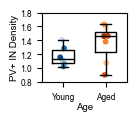

2.2754970000000003e-05 7.90357335834832e-06
4.051881428571428e-05 3.973503677003012e-06
-2.0 0.04550026389635839
0.5537231150832669 0.04961028569447767
-0.4715554579382478 0.10378975857104723


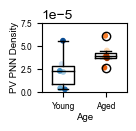

In [16]:
'Plot Figure 8B & Compare the Density of PV INs & PNNs in Young vs. Aged Mice'

# Check in PV IN Density is Altered
print(np.mean(youngPV), stats.sem(youngPV))
print(np.mean(agedPV), stats.sem(agedPV))

F, p = stats.ranksums(youngPV, agedPV)
print(F, p)

r, p = stats.pearsonr(np.concatenate((youngPV, agedPV)), hapln4)
print(r, p)

r, p = stats.pearsonr(np.concatenate((youngPV, agedPV)), coherence)
print(r, p)

#Plot Figure 8B Top
fig, ax = plt.subplots(figsize = (1.1,0.9))
per99 = [youngPV,agedPV]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=7, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=6)
ax.set_ylabel('PV+ IN Density', fontsize=7, labelpad=1)
ax.set_ylim([0.8e-4,1.8e-4])
ax.set_yticks([0.8e-4,1.0e-4,1.2e-4,1.4e-4,1.6e-4,1.8e-4])
ax.set_yticklabels([0.8,1.0,1.2,1.4,1.6,1.8])
ax.tick_params(labelsize = 6)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0], edgecolors = col_animal[i][0], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '8Btop.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '8Btop.svg', dpi=400, bbox_inches='tight')
plt.show()

# Check in PNN Density is Altered
print(np.mean(youngPNN), stats.sem(youngPNN))
print(np.mean(agedPNN), stats.sem(agedPNN))

F, p = stats.ranksums(youngPNN, agedPNN)
print(F, p)

r, p = stats.pearsonr(np.concatenate((youngPNN, agedPNN)), hapln4)
print(r, p)

r, p = stats.pearsonr(np.concatenate((youngPNN, agedPNN)), coherence)
print(r, p)

#Plot Figure 8B Bottom
fig, ax = plt.subplots(figsize = (1.1,0.9))
per99 = [youngPNN,agedPNN]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=7, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=6)
ax.set_ylabel('PV PNN Density', fontsize=7, labelpad=1)
ax.set_ylim([0,7.5e-5])
ax.set_yticks([0,2.5e-5,5e-5,7.5e-5])

ax.tick_params(labelsize = 6)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0], edgecolors = col_animal[i][0], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '8Bbottom.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '8Bbottom.svg', dpi=400, bbox_inches='tight')
plt.show()

1.5765333333333333e-05 5.534014270410866e-06
2.5509642857142857e-05 2.348228257021627e-06
-1.2857142857142858 0.19854279368666194
0.42975971428979914 0.142741540500669
-0.08839450922370669 0.7739904850353764
-0.28009532392652253 0.3539865049796788


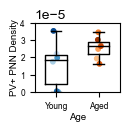

6.989633333333334e-06 2.7654410420602192e-06
1.5009185714285713e-05 2.4932706020338e-06
-2.0 0.04550026389635839
0.6288523108308532 0.02131490908424954
-0.4259980120523903 0.1466587127445006
-0.6596113730699306 0.014171897091067556


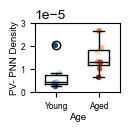

In [17]:
'Plot Figure 8C & Compare the Density of PV+ & PV- PNNs in Young vs. Aged Mice'

# Check in PV+ PNN Density is Altered
print(np.mean(youngPVPNN), stats.sem(youngPVPNN))
print(np.mean(agedPVPNN), stats.sem(agedPVPNN))

F, p = stats.ranksums(youngPVPNN, agedPVPNN)
print(F, p)

r, p = stats.pearsonr(np.concatenate((youngPVPNN, agedPVPNN)), hapln4)
print(r, p)

r, p = stats.pearsonr(np.concatenate((youngPVPNN, agedPVPNN)), stability)
print(r, p)

r, p = stats.pearsonr(np.concatenate((youngPVPNN, agedPVPNN)), coherence)
print(r, p)

#Plot Figure 8C Top
fig, ax = plt.subplots(figsize = (1.1,0.9))
per99 = [youngPVPNN,agedPVPNN]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=7, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=6)
ax.set_ylabel('PV+ PNN Density', fontsize=7, labelpad=1)
ax.set_ylim([0,4e-5])
ax.tick_params(labelsize = 6)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0], edgecolors = col_animal[i][0], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '8Ctop.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '8Ctop.svg', dpi=400, bbox_inches='tight')
plt.show()

# Check in PV- PNN Density is Altered
print(np.mean(youngEXPNN), stats.sem(youngEXPNN))
print(np.mean(agedEXPNN), stats.sem(agedEXPNN))

F, p = stats.ranksums(youngEXPNN, agedEXPNN)
print(F, p)

r, p = stats.pearsonr(np.concatenate((youngEXPNN, agedEXPNN)), hapln4)
print(r, p)

r, p = stats.pearsonr(np.concatenate((youngEXPNN, agedEXPNN)), stability)
print(r, p)

r, p = stats.pearsonr(np.concatenate((youngEXPNN, agedEXPNN)), coherence)
print(r, p)

#Plot Figure 8C Bottom
fig, ax = plt.subplots(figsize = (1.1,0.9))
per99 = [youngEXPNN,agedEXPNN]
labels = ['Young','Aged']
w = 0.5

plt.boxplot(per99, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session Spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=7, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=6)
ax.set_ylabel('PV- PNN Density', fontsize=7, labelpad=1)
ax.set_ylim([0,3e-5])
ax.tick_params(labelsize = 6)

for i in range(len(per99)):
    y = per99[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_animal[i][0], edgecolors = col_animal[i][0], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
plt.savefig(save_folder + '8Cbottom.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + '8Cbottom.svg', dpi=400, bbox_inches='tight')
plt.show()


Association btwn Young, Aged, & All Decoder Score vs. hapln4:
R [Young, Aged, All]: 
0.6101230636175762 0.4038979640962013 0.628852310830853
P [Young, MA, Aged, All]: 
0.19837460639007598 0.3688535980580756 0.021314909084249576


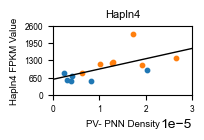


Association btwn Young, Aged, & All Decoder Score vs. Coherence:
R [Young, Aged, All]: 
0.2495454497473149 -0.7503251888671619 -0.6596113730699306
P [Young, MA, Aged, All]: 
0.6334517887268545 0.052021780085838354 0.0141718970910675


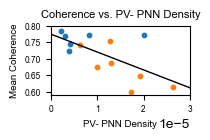

In [18]:
'''Plot 8D'''

#Hapln4 EXPNN
res = stats.linregress(youngEXPNN,hapln4[:6])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(agedEXPNN,hapln4[6:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(np.concatenate((youngEXPNN, agedEXPNN)),hapln4)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. hapln4:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7Rtop
fig, ax = plt.subplots(figsize = (1.8,0.9))
ax.set_title('Hapln4', fontsize = 8)
ax.scatter(youngEXPNN, hapln4[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(agedEXPNN, hapln4[6:], color = 'C1', label = 'Aged', s = 10)
ax.set_ylabel('Hapln4 FPKM Value', fontsize = 7)
ax.set_xlabel('PV- PNN Density', fontsize = 7)
ax.set_ylim([0,2600])
ax.set_yticks([0,650,1300,1950,2600])
ax.set_xlim([0,3e-5])
ax.set_xticks([0,1e-5,2e-5,3e-5])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '8Dtop.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '8Dtop.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Coherence vs EXPNN
res = stats.linregress(youngEXPNN,coherence[:6],)
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(agedEXPNN,coherence[6:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(np.concatenate((youngEXPNN, agedEXPNN)),coherence)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. Coherence:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7:bottom
fig, ax = plt.subplots(figsize = (1.8,0.9))
ax.set_title('Coherence vs. PV- PNN Density', fontsize = 8)
ax.scatter(youngEXPNN, coherence[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter( agedEXPNN,coherence[6:], color = 'C1', label = 'Aged', s = 10)
ax.set_ylabel('Mean Coherence', fontsize = 7)
ax.set_xlabel('PV- PNN Density', fontsize = 7)
ax.set_ylim([0.59,0.8])
ax.set_xlim([0,3e-5])
ax.set_xticks([0,1e-5,2e-5,3e-5])
ax.set_yticks([0.6,0.65,0.7,0.75,0.8])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + '8Dbottom.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + '8Dbottom.svg', dpi = 400, bbox_inches = 'tight')
plt.show()



Association btwn Young, Aged, & All Decoder Score vs. hapln4:
R [Young, Aged, All]: 
0.46539178330974346 0.34829106224904144 0.5537231150832667
P [Young, MA, Aged, All]: 
0.35231181464685485 0.44392332844026905 0.04961028569447775


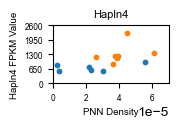


Association btwn Young, Aged, & All Decoder Score vs. Coherence:
R [Young, Aged, All]: 
0.33319194128745705 -0.5116902621991055 -0.47155545793824777
P [Young, MA, Aged, All]: 
0.5187070512407957 0.2404311033421337 0.10378975857104712


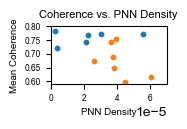

In [20]:
'''Plot 8D with all PNNs'''

#Hapln4 PNN
res = stats.linregress(youngPNN,hapln4[:6])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(agedPNN,hapln4[6:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(np.concatenate((youngPNN, agedPNN)),hapln4)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. hapln4:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7Ptop
fig, ax = plt.subplots(figsize = (1.5,0.75))
ax.set_title('Hapln4', fontsize = 8)
ax.scatter(youngPNN, hapln4[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(agedPNN, hapln4[6:], color = 'C1', label = 'Aged', s = 10)
ax.set_ylabel('Hapln4 FPKM Value', fontsize = 7)
ax.set_xlabel('PNN Density', fontsize = 7)
ax.set_ylim([0,2600])
ax.set_yticks([0,650,1300,1950,2600])
ax.set_xlim([0,7e-5])
ax.set_xticks([0,2e-5,4e-5,6e-5])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.show()

#Coherence vs PNN
res = stats.linregress(youngPNN,coherence[:6],)
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(agedPNN,coherence[6:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(np.concatenate((youngPNN, agedPNN)),coherence)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, Aged, & All Decoder Score vs. Coherence:')
print('R [Young, Aged, All]: ')
print(yr2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, ap2, allp2)

#Plot Figure 7:bottom
fig, ax = plt.subplots(figsize = (1.5,0.75))
ax.set_title('Coherence vs. PNN Density', fontsize = 8)
ax.scatter(youngPNN, coherence[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter( agedPNN,coherence[6:], color = 'C1', label = 'Aged', s = 10)
ax.set_ylabel('Mean Coherence', fontsize = 7)
ax.set_xlabel('PNN Density', fontsize = 7)
ax.set_ylim([0.59,0.8])
ax.set_xlim([0,7e-5])
ax.set_xticks([0,2e-5,4e-5,6e-5])
ax.set_yticks([0.6,0.65,0.7,0.75,0.8])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.show()


# Figure S8B-C, Q Visualizations of SM Transcriptomic Data Correlates of Spatial Coding and Memory

Other panels in Figure S8 were generated with publicly available packages listed in the manuscript methods. As such, the only code needed to reproduce these panels is shared. Raw and processed transcriptomic data will be made available to the public upon manuscript publication.

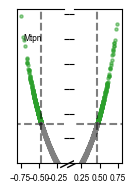

In [21]:
''' Plot Figure S8B Left'''

s8dbehavior = pd.read_csv('C:/Users/Python/Downloads/S8D_Behavior.csv') # adjust path name
s8dbehavior.head()

sigcorrR = np.array(s8dbehavior.loc[(s8dbehavior.sig == 1),'r'])
nscorrR = np.array(s8dbehavior.loc[(s8dbehavior.sig == 0),'r'])

sigcorrp = np.array(s8dbehavior.loc[(s8dbehavior.sig == 1),'p'])
nscorrp = np.array(s8dbehavior.loc[(s8dbehavior.sig == 0),'p'])

gabra2p = np.array(s8dbehavior.loc[(s8dbehavior.Gene == 'Gabra2'),'p'])
gabra2r = np.array(s8dbehavior.loc[(s8dbehavior.Gene == 'Gabra2'),'r'])
mtpnp = np.array(s8dbehavior.loc[(s8dbehavior.Gene == 'Mtpn'),'p'])
mtpnr = np.array(s8dbehavior.loc[(s8dbehavior.Gene == 'Mtpn'),'r'])

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (1.35,2),sharey = True)
fig.subplots_adjust(wspace = 0.2)
ax1.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax1.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax1.set_xlim([-0.8,-0.15])
ax1.set_xticks([-0.75,-0.5,-0.25])
#ax1.set_ylim([0.85,3.75])
ax2.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax2.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax2.set_xlim([0.15,0.8])
ax2.set_xticks([0.25,0.5,0.75])
ax2.set_ylim([0.5,3.6])
ax2.set_yticks([0.5,1,1.5,2,2.5,3,3.5])
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_right()
ax1.tick_params(labelright=False, labelsize = 6)
ax2.tick_params(labelsize = 6)
ax2.yaxis.tick_left()

ax1.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax2.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax1.vlines(np.min(nscorrR),0.5,3.6,'k','--',alpha = 0.5)
ax2.vlines(np.max(nscorrR),0.5,3.6,'k','--',alpha = 0.5)

#ax2.annotate('Gabra2',(gabra2r,-1*np.log10(gabra2p)),fontsize = 6)
ax1.annotate('Mtpn',(mtpnr,-1*np.log10(mtpnp)),fontsize = 6)

#add slant broken line
d = 0.5
kwargs = dict(marker=[(-1,-d),(1,d)], markersize = 12, linestyle = "none",color = 'k', mec = 'k', mew = 1, clip_on=False)
ax1.plot([1.08,1.22],[0,0], transform=ax1.transAxes,**kwargs)
#ax2.plot([0,1],[1,1], transform=ax2.transAxes,**kwargs)

plt.savefig(save_folder + 'S8Bleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Bleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


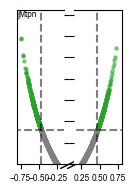

In [22]:
''' Plot Figure S8B Middle'''

s8dfrac = pd.read_csv('C:/Users/Python/Downloads/S8D_fracaligned.csv') # adjust path name
s8dfrac.head()

sigcorrR = np.array(s8dfrac.loc[(s8dfrac.sig == 1),'r'])
nscorrR = np.array(s8dfrac.loc[(s8dfrac.sig == 0),'r'])

sigcorrp = np.array(s8dfrac.loc[(s8dfrac.sig == 1),'p'])
nscorrp = np.array(s8dfrac.loc[(s8dfrac.sig == 0),'p'])

gabra2p = np.array(s8dfrac.loc[(s8dfrac.Gene == 'Gabra2'),'p'])
gabra2r = np.array(s8dfrac.loc[(s8dfrac.Gene == 'Gabra2'),'r'])
mtpnp = np.array(s8dfrac.loc[(s8dfrac.Gene == 'Mtpn'),'p'])
mtpnr = np.array(s8dfrac.loc[(s8dfrac.Gene == 'Mtpn'),'r'])

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (1.35,2),sharey = True)
fig.subplots_adjust(wspace = 0.2)
ax1.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax1.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax1.set_xlim([-0.8,-0.15])
ax1.set_xticks([-0.75,-0.5,-0.25])
#ax1.set_ylim([0.85,3.75])
ax2.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax2.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax2.set_xlim([0.15,0.8])
ax2.set_xticks([0.25,0.5,0.75])
ax2.set_ylim([0.5,4.1])
ax2.set_yticks([0.5,1,1.5,2,2.5,3,3.5,4])
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_right()
ax1.tick_params(labelright=False, labelsize = 6)
ax2.tick_params(labelsize = 6)
ax2.yaxis.tick_left()

ax1.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax2.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax1.vlines(np.min(nscorrR),0.5,4.1,'k','--',alpha = 0.5)
ax2.vlines(np.max(nscorrR),0.5,4.1,'k','--',alpha = 0.5)

#ax2.annotate('Gabra2',(gabra2r,-1*np.log10(gabra2p)),fontsize = 6)
ax1.annotate('Mtpn',(mtpnr,-1*np.log10(mtpnp)),fontsize = 6)

#add slant broken line
d = 0.5
kwargs = dict(marker=[(-1,-d),(1,d)], markersize = 12, linestyle = "none",color = 'k', mec = 'k', mew = 1, clip_on=False)
ax1.plot([1.08,1.22],[0,0], transform=ax1.transAxes,**kwargs)
#ax2.plot([0,1],[1,1], transform=ax2.transAxes,**kwargs)

plt.savefig(save_folder + 'S8Bmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Bmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


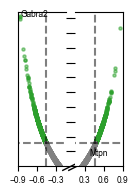

In [24]:
''' Plot Figure S8B Right'''

s8dremap = pd.read_csv('C:/Users/Python/Downloads/S8D_Remap.csv') # adjust path name
s8dremap.head()

sigcorrR = np.array(s8dremap.loc[(s8dremap.sig == 1),'r'])
nscorrR = np.array(s8dremap.loc[(s8dremap.sig == 0),'r'])

sigcorrp = np.array(s8dremap.loc[(s8dremap.sig == 1),'p'])
nscorrp = np.array(s8dremap.loc[(s8dremap.sig == 0),'p'])

gabra2p = np.array(s8dremap.loc[(s8dremap.Gene == 'Gabra2'),'p'])
gabra2r = np.array(s8dremap.loc[(s8dremap.Gene == 'Gabra2'),'r'])
mtpnp = np.array(s8dremap.loc[(s8dremap.Gene == 'Mtpn'),'p'])
mtpnr = np.array(s8dremap.loc[(s8dremap.Gene == 'Mtpn'),'r'])

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (1.35,2),sharey = True)
fig.subplots_adjust(wspace = 0.2)
ax1.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax1.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax1.set_xlim([-0.9,-0.15])
ax1.set_xticks([-0.9,-0.6,-0.3])
ax2.scatter(sigcorrR,-1*np.log10(sigcorrp), color = 'C2', alpha = 0.5, s = 5)
ax2.scatter(nscorrR,-1*np.log10(nscorrp), color = 'grey', alpha = 0.5, s = 5)
ax2.set_xlim([0.15,0.9])
ax2.set_xticks([0.3,0.6,0.9])
ax2.set_ylim([0.5,5.7])
ax2.set_yticks([0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_right()
ax1.tick_params(labelright=False, labelsize = 6)
ax2.tick_params(labelsize = 6)
ax2.yaxis.tick_left()

ax1.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax2.hlines(np.max(-1*np.log10(nscorrp)),-1,1,'k','--',alpha = 0.5)
ax1.vlines(np.min(nscorrR),0.5,5.7,'k','--',alpha = 0.5)
ax2.vlines(np.max(nscorrR),0.5,5.7,'k','--',alpha = 0.5)

ax1.annotate('Gabra2',(gabra2r,-1*np.log10(gabra2p)),fontsize = 6)
ax2.annotate('Mtpn',(mtpnr,-1*np.log10(mtpnp)),fontsize = 6)

#add slant broken line
d = 0.5
kwargs = dict(marker=[(-1,-d),(1,d)], markersize = 12, linestyle = "none",color = 'k', mec = 'k', mew = 1, clip_on=False)
ax1.plot([1.08,1.22],[0,0], transform=ax1.transAxes,**kwargs)
#ax2.plot([0,1],[1,1], transform=ax2.transAxes,**kwargs)

plt.savefig(save_folder + 'S8Bright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Bright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()



Association btwn Young, MA, Aged, & All Mtpn vs. Change in Alt Frac. Req
R [Young, Aged, All]: 
-0.6073658832297203 0.2269916366302728 0.6881929495886212 -0.7066421464280799
P [Young, MA, Aged, All]: 
0.20097778253419524 0.6653604401442892 0.13067794733666344 0.0010434830929581397


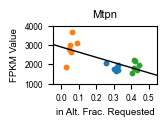


Association btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:
R [Young, Aged, All]: 
-0.854772189082721 -0.230145408595067 0.2840847557220249 -0.785360883938715
P [Young, MA, Aged, All]: 
0.030105167215247728 0.6608769325755178 0.5853362755637253 0.00011259646759687579


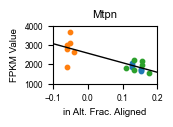


Association btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:
R [Young, Aged, All]: 
-0.028544379590161168 0.1999932886870057 -0.3883781874264254 -0.8694166848386659
P [Young, MA, Aged, All]: 
0.9571950593324833 0.7040096643042242 0.4467237389002676 2.799733649282276e-06


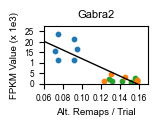

In [25]:
''' Plot Figure S8C '''

behavior = [0.257799,0.311668,0.321791,0.319969,0.303089,0.322289,0.421861,0.41576,0.445066,0.403321,0.415839,0.432759,0.060951,0.055986,0.087271,0.025026,0.04029,0.050669]
fracaligned = [0.126553,0.151863,0.151863,0.126553,0.151863,0.126552,0.154545,0.110389,0.154545,0.176623,0.132467,0.132467,-0.049954,-0.039964,-0.049955,-0.059946,-0.059946,-0.059946]
remapfreq = [0.071971,0.0754,0.0754,0.091645,0.095074,0.091645,0.15783,0.128946,0.132446,0.142946,0.15223,0.15643,0.131168,0.123771,0.145961,0.158238,0.158238,0.158238]
mtpn = [2077.613307,1680.409735,1713.971316,1844.118878,1780.820656,1984.860489,2156.837812,1836.161707,1989.678908,1551.350236,2253.11969,1692.371425,3704.186916,2657.341693,3136.999221,1854.415688,2804.86934,3012.776551]
gabra2 = [15759.13646,11235.44523,23606.63313,11091.98657,16717.31204,21455.4798,1805.136953,2082.048142,1039.74403,1169.752883,936.5640468,2444.497356,4344.601994,1139.070836,2915.195789,1792.112699,886.1942631,1413.803835]
egr1 = [1046.813834,1910.143313,1768.46177,3563.943914,1109.375195,2482.352907,3174.649182,1696.101779,1399.826301,1650.854012,2792.348611,2125.798969,3330.430531,3189.258313,4443.43422,1391.719477,1725.042651,1479.942271]
arc = [2596.988733,3534.566302,4750.366731,4492.280658,2835.214967,3518.543982,4309.795667,4478.890383,1159.850154,3494.217766,4256.690128,704.435914,6758.533199,6395.058947,5332.508232,2742.934978,1934.945579,2245.915838]

res = stats.linregress(behavior[:6],mtpn[:6])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(behavior[6:12],mtpn[6:12])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(behavior[12:],mtpn[12:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(behavior,mtpn)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Mtpn vs. Change in Alt Frac. Req')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Figure S8Cleft
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Mtpn', fontsize = 8)
ax.scatter(behavior[:6],mtpn[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(behavior[6:12],mtpn[6:12], color = 'C2', label = 'MA', s = 10)
ax.scatter(behavior[12:],mtpn[12:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('in Alt. Frac. Requested', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([-0.05,0.55])
ax.set_ylim([1000,4000])
ax.set_yticks([1000,2000,3000,4000])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Cleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Cleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Middle
res = stats.linregress(fracaligned[:6],mtpn[:6])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(fracaligned[6:12],mtpn[6:12])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(fracaligned[12:],mtpn[12:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(fracaligned, mtpn)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Figure S8Cmiddle
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Mtpn', fontsize = 8)
ax.scatter(fracaligned[:6],mtpn[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(fracaligned[6:12],mtpn[6:12], color = 'C2', label = 'MA', s = 10)
ax.scatter(fracaligned[12:],mtpn[12:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('in Alt. Frac. Aligned', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([-0.1,0.2])
ax.set_ylim([1000,4000])
ax.set_yticks([1000,2000,3000,4000])
ax.set_xticks([-0.1,0,0.1,0.2])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Cmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Cmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Right
res = stats.linregress(remapfreq[:6],gabra2[:6])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(remapfreq[6:12],gabra2[6:12])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(remapfreq[12:],gabra2[12:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(remapfreq, gabra2)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Figure S8Cright
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Gabra2', fontsize = 8)
ax.scatter(remapfreq[:6],gabra2[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(remapfreq[6:12],gabra2[6:12], color = 'C2', label = 'MA', s = 10)
ax.scatter(remapfreq[12:],gabra2[12:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Alt. Remaps / Trial', fontsize = 7)
ax.set_ylabel('FPKM Value (x 1e3)', fontsize = 7)
ax.set_xlim([0.06,0.17])
ax.set_ylim([-100,27500])
ax.set_yticks([0,5000,10000,15000,20000,25000])
ax.set_yticklabels([0,5,1,15,20,25])
ax.set_xticks([0.06,0.08,0.10,0.12,0.14,0.16])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
#ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Cright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Cright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()


Association btwn Young, MA, Aged, & All egr1 vs. Change in Alt Frac. Req
R [Young, Aged, All]: 
0.634216460836225 -0.1838348522120269 0.9063587652800464 -0.1617133002889403
P [Young, MA, Aged, All]: 
0.17622591690794626 0.7273540943420097 0.012742466209460493 0.5214723933964371


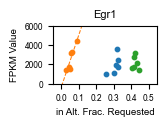


Association btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:
R [Young, Aged, All]: 
0.10846462738339158 -0.13761243555985495 0.8932595652075174 -0.24021296664450412
P [Young, MA, Aged, All]: 
0.8379410790680981 0.7948843425579956 0.016482205967825073 0.33698917949422813


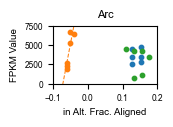


Association btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:
R [Young, Aged, All]: 
0.01182672751840573 -0.019627727796524202 -0.9406816391729679 -0.16309873059545577
P [Young, MA, Aged, All]: 
0.9822607358333546 0.9705621890736935 0.005173641089822076 0.5178620980254787


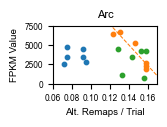

In [26]:
''' Plot Figure S8Q''' 
res = stats.linregress(behavior[:6],egr1[:6])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(behavior[6:12],egr1[6:12])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(behavior[12:],egr1[12:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(behavior,egr1)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All egr1 vs. Change in Alt Frac. Req')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Figure S8Qleft
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Egr1', fontsize = 8)
ax.scatter(behavior[:6],egr1[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(behavior[6:12],egr1[6:12], color = 'C2', label = 'MA', s = 10)
ax.scatter(behavior[12:],egr1[12:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('in Alt. Frac. Requested', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([-0.05,0.55])
ax.set_ylim([0,6000])
ax.set_yticks([0,2000,4000,6000])
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
#ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Qleft.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Qleft.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Middle
res = stats.linregress(fracaligned[:6],arc[:6])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(fracaligned[6:12],arc[6:12])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(fracaligned[12:],arc[12:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(fracaligned, arc)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Figure S8Qmiddle
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Arc', fontsize = 8)
ax.scatter(fracaligned[:6],arc[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(fracaligned[6:12],arc[6:12], color = 'C2', label = 'MA', s = 10)
ax.scatter(fracaligned[12:],arc[12:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('in Alt. Frac. Aligned', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([-0.1,0.2])
ax.set_ylim([0,7500])
ax.set_yticks([0,2500,5000,7500])
ax.set_xticks([-0.1,0,0.1,0.2])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
#ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Qmiddle.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Qmiddle.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

#Right
res = stats.linregress(remapfreq[:6],arc[:6])
yslope2 = res.slope; yint2 = res.intercept; yr2 = res.rvalue; yp2 = res.pvalue

res = stats.linregress(remapfreq[6:12],arc[6:12])
maslope2 = res.slope; maint2 = res.intercept; mar2 = res.rvalue ; map2 = res.pvalue

res = stats.linregress(remapfreq[12:],arc[12:])
aslope2 = res.slope; aint2 = res.intercept; ar2 = res.rvalue ; ap2 = res.pvalue

res = stats.linregress(remapfreq, arc)
allslope2 = res.slope; allint2 = res.intercept; allr2 = res.rvalue; allp2 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Change in Alt. Frac ALigned:')
print('R [Young, Aged, All]: ')
print(yr2, mar2, ar2, allr2)
print('P [Young, MA, Aged, All]: ')
print(yp2, map2, ap2, allp2)

#Plot Figure S8Qright
fig, ax = plt.subplots(figsize = (1.35,0.75))
ax.set_title('Arc', fontsize = 8)
ax.scatter(remapfreq[:6],arc[:6], color = 'C0', label = 'Young', s = 10)
ax.scatter(remapfreq[6:12],arc[6:12], color = 'C2', label = 'MA', s = 10)
ax.scatter(remapfreq[12:],arc[12:], color = 'C1', label = 'Aged', s = 10)
ax.set_xlabel('Alt. Remaps / Trial', fontsize = 7)
ax.set_ylabel('FPKM Value', fontsize = 7)
ax.set_xlim([0.06,0.17])
ax.set_ylim([0,7500])
ax.set_yticks([0,2500,5000,7500])
ax.set_xticks([0.06,0.08,0.10,0.12,0.14,0.16])
ax.tick_params(labelsize = 6)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
#ax.plot(X_plot, yslope2*X_plot + yint2, '--', linewidth = 0.75, color = 'C0', label = 'Young Fit')
ax.plot(X_plot, aslope2*X_plot + aint2, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
#ax.plot(X_plot, allslope2*X_plot + allint2, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
plt.savefig(save_folder + 'S8Qright.png', dpi = 400, bbox_inches = 'tight')
plt.savefig(save_folder + 'S8Qright.svg', dpi = 400, bbox_inches = 'tight')
plt.show()